#**1. Cargar Librerías**

In [ ]:
!pip install kneed
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
import seaborn as sns
from kneed import KneeLocator
from termcolor import colored, cprint
%matplotlib inline 

#**2. Cargar dataset limpiado y procesado por lenguiaje natural**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

ruta_data='/content/gdrive/MyDrive/DIPLOMADO BIGDATA/MODULO V/TRABAJO FINAL/DATA FILTRADA POR DAVID/dataset_aesi(final, 2210-variables).csv'
data=pd.read_csv(ruta_data)


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


#**3. LIMPIADO SECUNDARIO Y CREACIÓN DE NUEVAS VARIABLES DE TIEMPO**

##3.1. Eliminamos observaciones de **unknown** de recovd

In [ ]:
data=data.loc[(data['recovd']=='N') | (data['recovd']=='Y')]

##3.2. Variables de tiempo days_to_onset_symptoms (días de incio de síntomas desde que se vacunó).

In [ ]:
# Convertir variables de fechas a formato datetime
from datetime import datetime
data['onset_date']=data['onset_date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
data['vax_date']=data['vax_date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
data['recvdate']=data['recvdate'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
#   Nueva variable days_to_onset_symptoms
data['days_to_onset_symptoms'] =  (data['onset_date'] - data['vax_date'])/np.timedelta64(1,'D')
data['days_to_onset_symptoms']=data['days_to_onset_symptoms'].astype(int)
##  Eliminar filas con intervalos negativos (producto de resitros erróneos)
data=data.loc[data['days_to_onset_symptoms']>0]


In [ ]:
## ELIMINACIÓN DE VARIABLES FECHAS ##
data.drop(['recvdate','vax_date','onset_date'],axis=1, inplace=True)

## 3.3. Eliminacion por criterio :
####VARIABLES NO INFORMATIVAS
***


1.   VAERS_ID : Todos los pacientes son diferentes y no se repite, es una etiqueta.
2.  Vax_site : Sitio físico de vacunación, no hay diccionario específico.
3.  vax_route : En la data además de intramuscular, indican desconocido, necesidad de una jeringa, otros y subcutáneo. No es específica, por lo que se obviará toda la variable.


####VARIABLES QUE PERTENECEN SOLO A EE.UU
****


1.   VAX_LOT : Lotes distribuidos a Estados Unidos, existen muchos errores de registro, "unknown" es la variable predominante en casi el 80%, filtrarla elimaría casi todo el Data_frame.
2.  STATE  : Los estados de EE.UU. 
3.   V_ADMINIBY: Diferencia ente privado y tipo de ente público que administra, para extrapolación a data peruana no es relevante.


In [ ]:
### ELIMINAR VARIABLES NO INFORMATIVAS POR SER DE VALOR ÚNICO O NO RELEVANTE DEBIDO A LA FILTRACIÓN PREVIA EN EL PROCESAMIENTO POR LENGUAJE NATURAL ###
data.drop(['VAERS_ID'], axis=1, inplace=True)
### ELIMINAR VARIABLES QUE NO SE PUEDEN REPETIR EN OTROS PAÍSES###
data.drop(['vax_lot', 'state'],axis=1 , inplace=True)
### ELIMINAR VARIABLES 
data.drop(['vax_site', 'v_adminby'],axis=1, inplace=True)
### ELIMINAR VAX_ROTE
data.drop('vax_route',axis=1,inplace=True)

##3.4. ELIMINACIÓN DE OBSERVACIONES POR CRITERIO :
#### 3.4.1. DOSIS DE LA VACUNAS : Solo hay 2 observaciones de pacientes con 3 dosis, por lo que no es posible establecer causalidad solo con esas dos observaciones.
#### 3.4.2. TIPO DE VACUNA: 

In [ ]:
data=data.loc[data['vax_dose_series']<3]

#**3. Exploración de Data**

In [ ]:
## DESCRIPCIÓN DEL DATA FRAME ###
cprint('Datos del Data Frame', color='blue', on_color='on_white', attrs=['bold'])
cprint(f'El Data Frame registra\t: {data.shape[0]} observaciones y {data.shape[1]} variables.', color='cyan', attrs=['bold'])
cprint('Tipo de datos', color='blue', on_color='on_white', attrs=['bold'])
cprint(f'Tipo\tcolumnas\n------------\n{data.dtypes.value_counts()}', color='cyan', attrs=['bold'])
cprint('Distribución de los datos por sexo', color='blue', on_color='on_white', attrs=['bold'])
cprint(f'Sexo\tCantidad\n------------\n{data.sex.value_counts()}', color='cyan', attrs=['bold'])

Datos del Data Frame
El Data Frame registra	: 1373 observaciones y 35 variables.
Tipo de datos
Tipo	columnas
------------
int64     32
object     3
dtype: int64
Distribución de los datos por sexo
Sexo	Cantidad
------------
M    762
F    611
Name: sex, dtype: int64


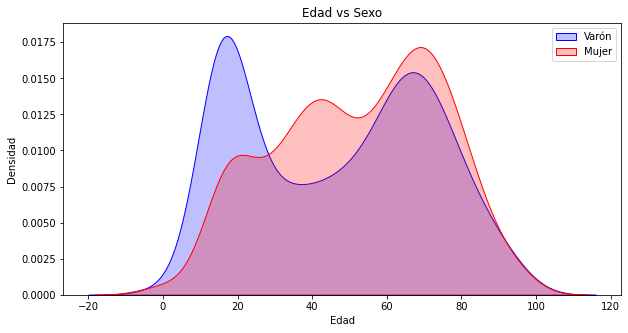

In [ ]:
#Distribución de Pacientes por Edad y Sexo
plt.figure(figsize=(10,5))
sns.kdeplot(data.age_yrs[data.sex == 'M'], color="blue", shade=True)
sns.kdeplot(data.age_yrs[data.sex == 'F'], color="red", shade=True)
plt.legend(['Varón', 'Mujer'])
plt.title('Edad vs Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

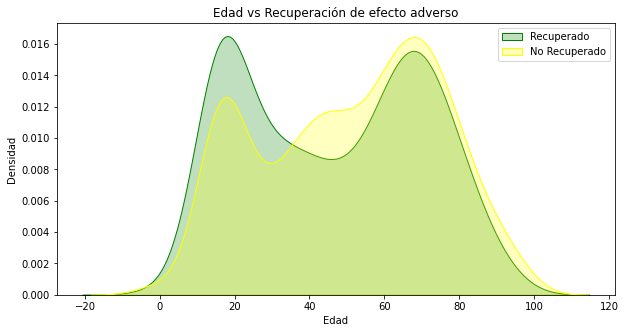

In [ ]:
#Distribución de Pacientes por Edad y Recuperación del efecto adverso
plt.figure(figsize=(10,5))
sns.kdeplot(data.age_yrs[data.recovd == 'Y'], color="green", shade=True)
sns.kdeplot(data.age_yrs[data.recovd == 'N'], color="yellow", shade=True)
plt.legend(['Recuperado', 'No Recuperado'])
plt.title('Edad vs Recuperación de efecto adverso')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

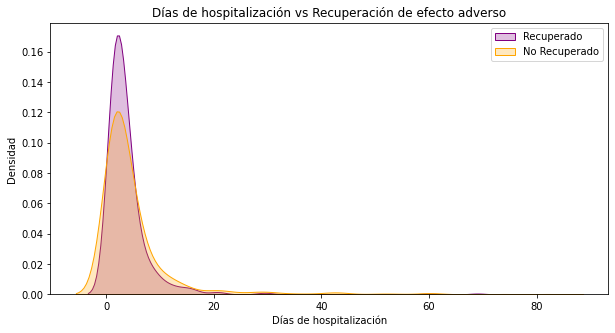

In [ ]:
#Distribución de Pacientes por Días de hospitalización y Recuperación del efecto adverso
plt.figure(figsize=(10,5))
sns.kdeplot(data.hospdays[data.recovd == 'Y'], color="purple", shade=True)
sns.kdeplot(data.hospdays[data.recovd == 'N'], color="orange", shade=True)
plt.legend(['Recuperado', 'No Recuperado', 'Desconocido'])
plt.title('Días de hospitalización vs Recuperación de efecto adverso')
plt.xlabel('Días de hospitalización')
plt.ylabel('Densidad')
plt.show()

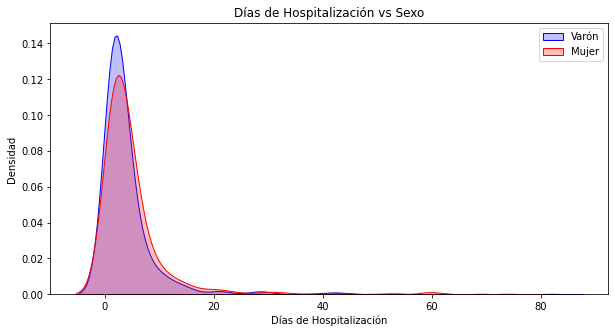

In [ ]:
#Distribución de Pacientes por Días de hospitalización y Sexo
plt.figure(figsize=(10,5))
sns.kdeplot(data.hospdays[data.sex == 'M'], color="blue", shade=True)
sns.kdeplot(data.hospdays[data.sex == 'F'], color="red", shade=True)
plt.legend(['Varón', 'Mujer'])
plt.title('Días de Hospitalización vs Sexo')
plt.xlabel('Días de Hospitalización')
plt.ylabel('Densidad')
plt.show()

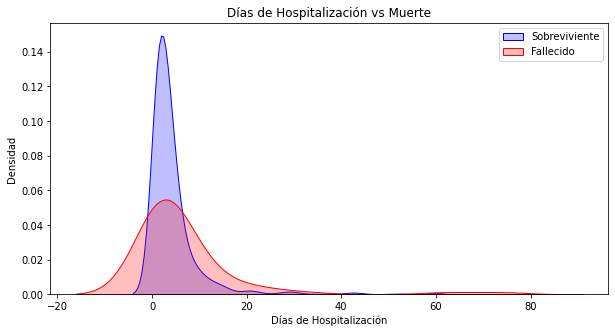

In [ ]:
#Distribución de Pacientes por Días de hospitalización y Fallecimiento
plt.figure(figsize=(10,5))
sns.kdeplot(data.hospdays[data.died == 'N'], color="blue", shade=True)
sns.kdeplot(data.hospdays[data.died == 'Y'], color="red", shade=True)
plt.legend(['Sobreviviente', 'Fallecido'])
plt.title('Días de Hospitalización vs Muerte')
plt.xlabel('Días de Hospitalización')
plt.ylabel('Densidad')
plt.show()

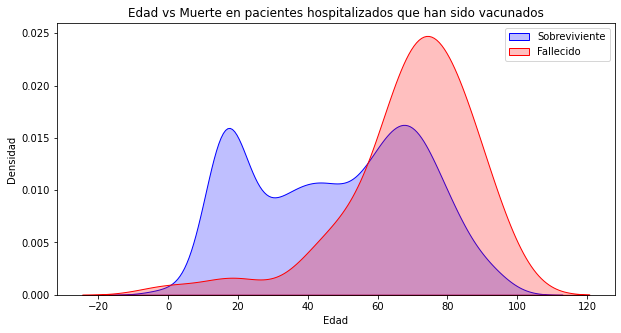

In [ ]:
#Distribución de Pacientes por Edad y Muerte
plt.figure(figsize=(10,5))
sns.kdeplot(data.age_yrs[data.died == 'N'], color="blue", shade=True)
sns.kdeplot(data.age_yrs[data.died == 'Y'], color="red", shade=True)
plt.legend(['Sobreviviente', 'Fallecido'])
plt.title('Edad vs Muerte en pacientes hospitalizados que han sido vacunados')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

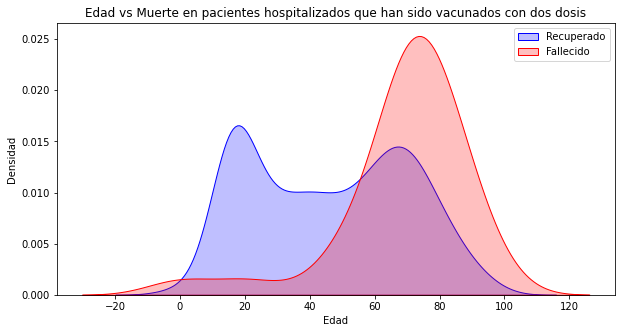

In [ ]:
#Distribución de Pacientes por Edad y Muerte
data2=data.copy()
data2=data2.loc[data2['vax_dose_series'] == 2]
plt.figure(figsize=(10,5))
sns.kdeplot(data2.age_yrs[data2.died == 'N'], color="blue", shade=True)
sns.kdeplot(data2.age_yrs[data2.died == 'Y'], color="red", shade=True)
plt.legend(['Recuperado', 'Fallecido'])
plt.title('Edad vs Muerte en pacientes hospitalizados que han sido vacunados con dos dosis')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

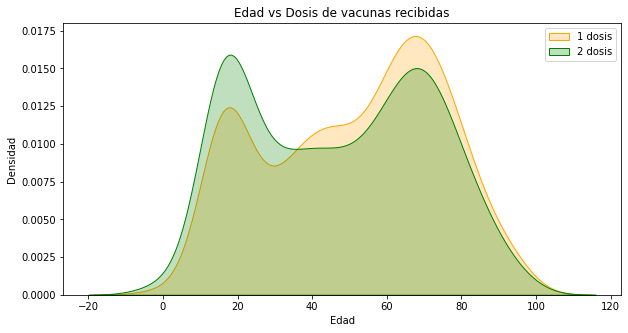

In [ ]:
#Distribución de Pacientes por Edad y DOSIS RECIBIDAS
plt.figure(figsize=(10,5))
sns.kdeplot(data.age_yrs[data.vax_dose_series == 1], color="orange", shade=True)
sns.kdeplot(data.age_yrs[data.vax_dose_series == 2], color="green", shade=True)
plt.legend(['1 dosis', '2 dosis'])
plt.title('Edad vs Dosis de vacunas recibidas')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

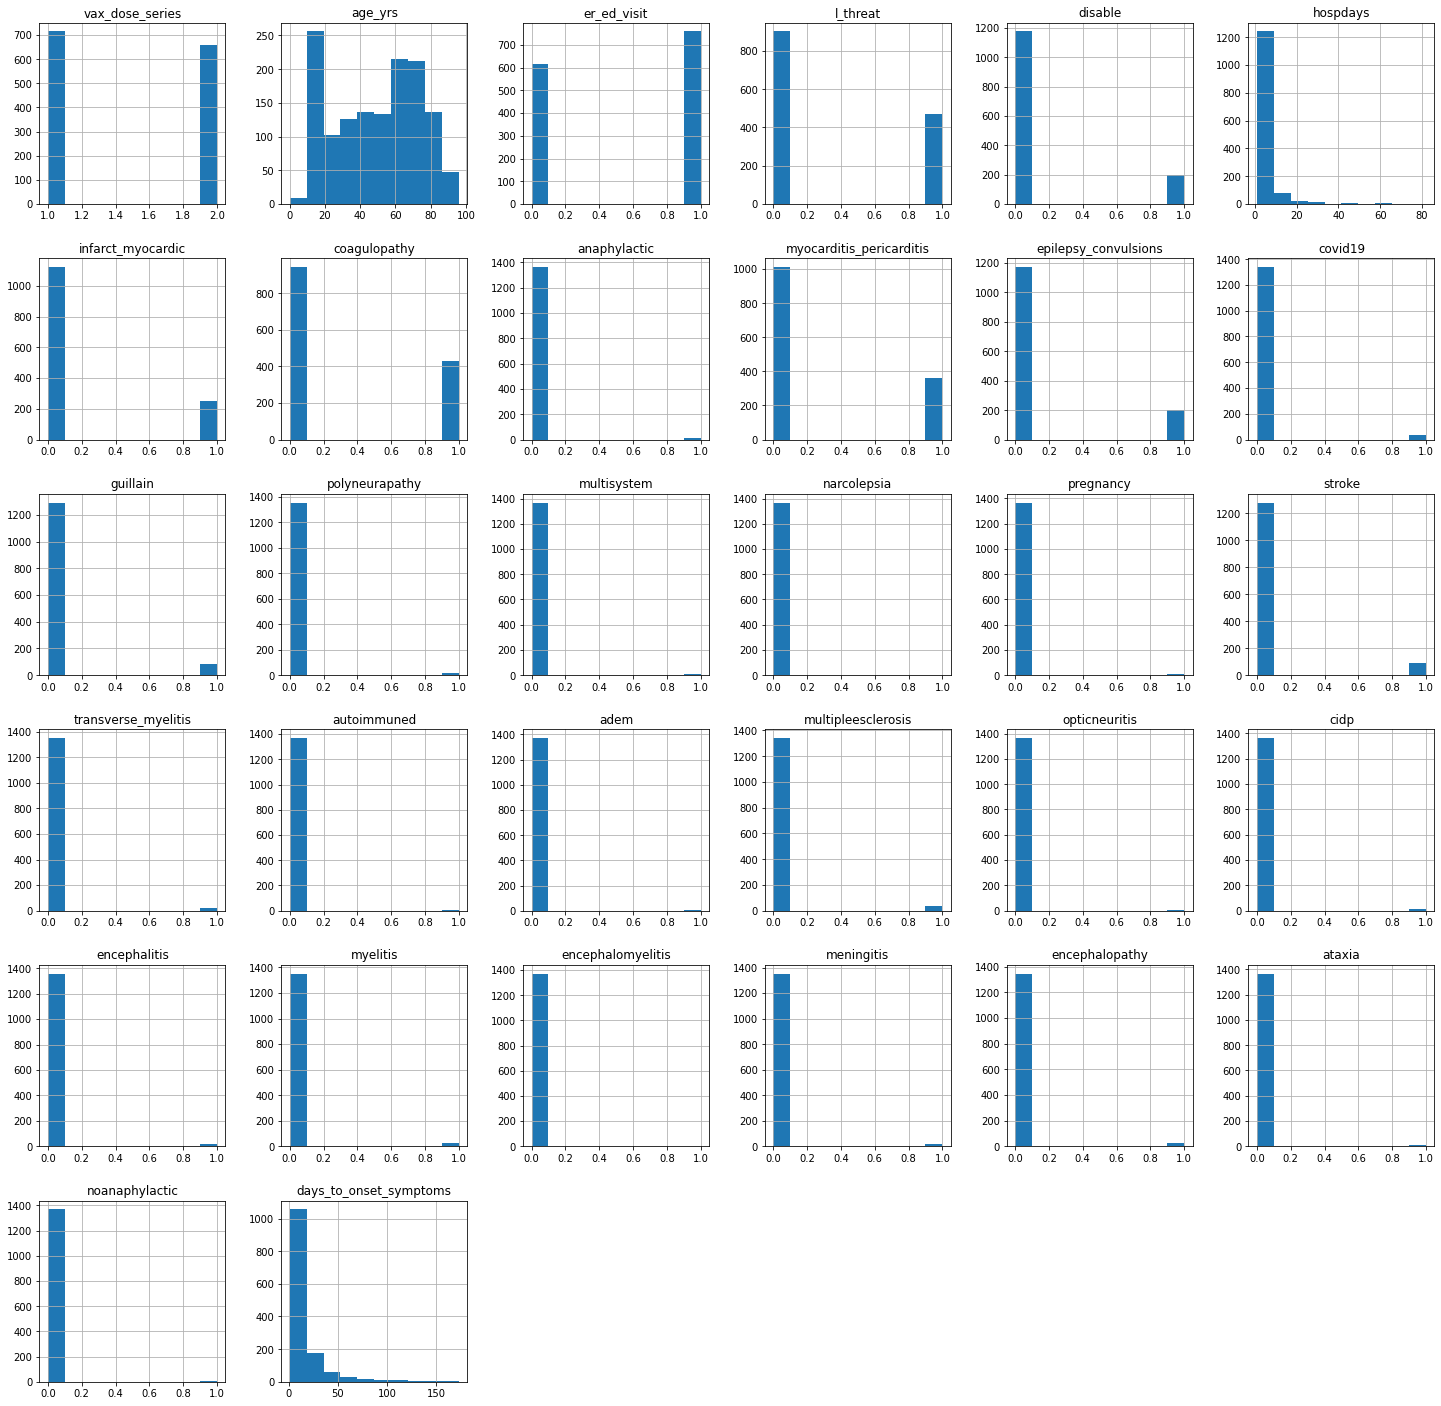

In [ ]:
#Distribuciones de variables
data.hist(figsize=(25, 25))
plt.show()

#**4.PRE-PROCESADO PARA MODELAJE**

In [ ]:
## Variables categóricas binarias convertidas a 0 y 1 ####
data['sex']=data['sex'].apply(lambda x : 0 if x == 'M' else 1) ## 0 para Maculinos , 1 para Femenino
data['died']=data['died'].apply(lambda x : 0 if x == 'N' else 1) ## 0 para N "NO FALLECIDO" , 1 para Y "FALLECIDO"
data['recovd']=data['recovd'].apply(lambda x : 0 if x == 'N' else 1) ## 0 para N "NO RECUPERADO" , 1 para Y "RECUPERADO"


In [ ]:
data.encephalomyelitis.value_counts()

0    1371
1       2
Name: encephalomyelitis, dtype: int64

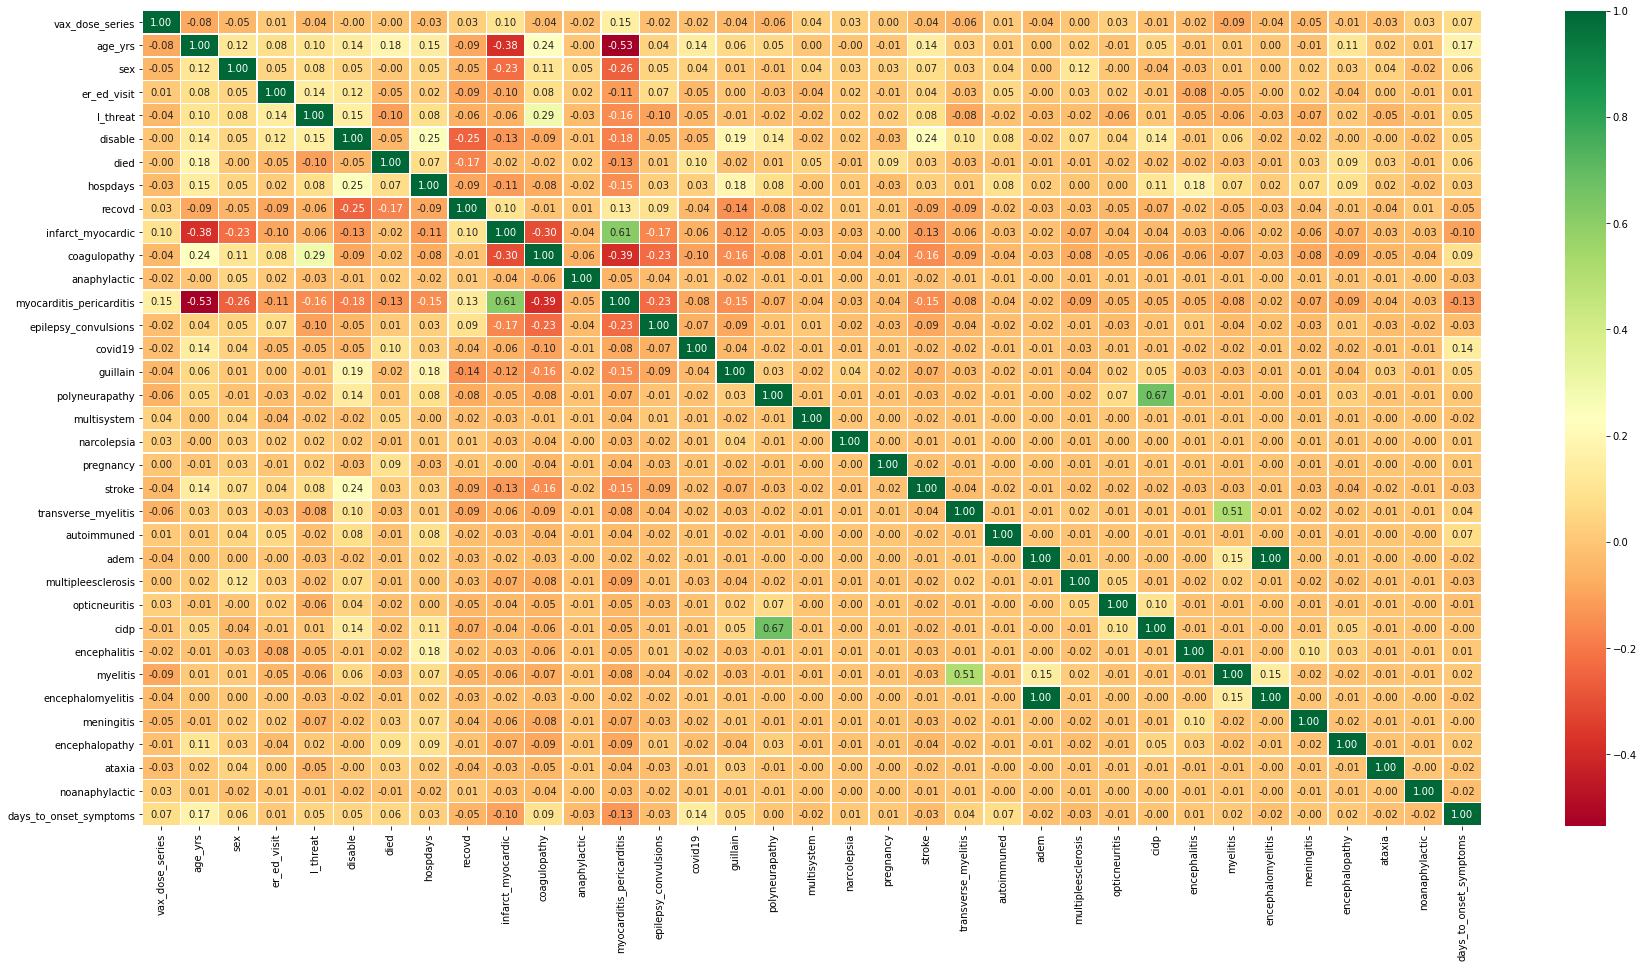

In [ ]:
#Correlación de variables
corr = data.corr()
sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(30, 15)
plt.show()

#**5. ALGORITOMOS MODELAMIENTO**

##5.1. k-means con todo el dataset

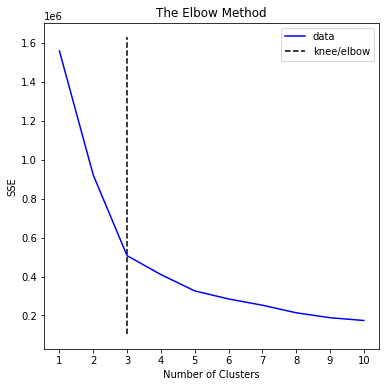

In [ ]:
#Choosing the Appropriate Number of Clusters
data_modelamiento=data.copy()
#data_modelamiento=data.loc[data['days_to_onset_symptoms']]

#The elbow method
sse = []

for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, max_iter=300, random_state=42).fit(data_modelamiento)
   sse.append(kmeans.inertia_)

kneedle = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

#plt.plot(range(1, 11), sse)
kneedle.plot_knee()
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('The Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=3000, random_state=42).fit(data_modelamiento)
kmeans.inertia_

507053.53699742974

In [ ]:
kmeans.cluster_centers_

array([[ 1.43085881e+00,  6.78573508e+01,  4.77438137e-01,
         5.89519651e-01,  3.79912664e-01,  1.79039301e-01,
         6.84133916e-02,  5.76710335e+00,  3.43522562e-01,
         6.11353712e-02,  4.00291121e-01,  1.01892285e-02,
         7.56914119e-02,  1.60116448e-01,  3.49344978e-02,
         7.13245997e-02,  2.03784571e-02,  4.36681223e-03,
         1.45560408e-03,  2.91120815e-03,  9.75254731e-02,
         1.74672489e-02,  2.91120815e-03,  1.45560408e-03,
         2.91120815e-02,  7.27802038e-03,  1.31004367e-02,
         1.31004367e-02,  1.74672489e-02,  1.45560408e-03,
         1.60116448e-02,  2.62008734e-02,  7.27802038e-03,
         4.36681223e-03,  1.07190684e+01],
       [ 1.51114923e+00,  2.53070326e+01,  4.01372213e-01,
         5.06003431e-01,  2.89879931e-01,  9.60548885e-02,
         1.02915952e-02,  3.32246998e+00,  4.37392796e-01,
         3.41337907e-01,  1.92109777e-01,  6.86106346e-03,
         5.07718696e-01,  1.35506003e-01,  1.71526587e-03,
         4.28

In [ ]:
# The number of iterations required to converge
kmeans.n_iter_

8

##***5.2. EVALUACIÓN DE VARIABLES QUE AUMENTAN LOS DÍAS DE HOSPITALIZACIÓN**

age_yrs vs vax_dose_series vs hospdays


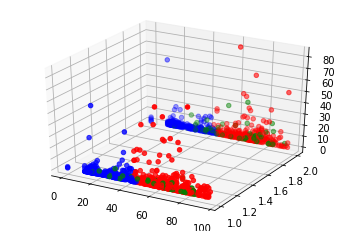

age_yrs vs age_yrs vs hospdays


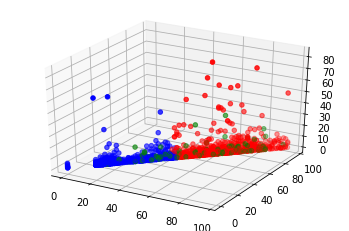

age_yrs vs sex vs hospdays


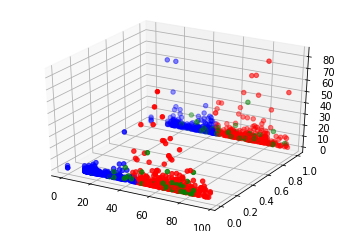

age_yrs vs er_ed_visit vs hospdays


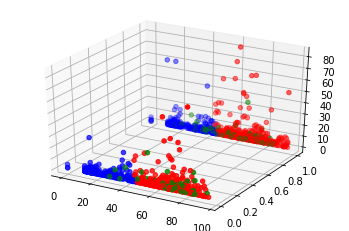

age_yrs vs l_threat vs hospdays


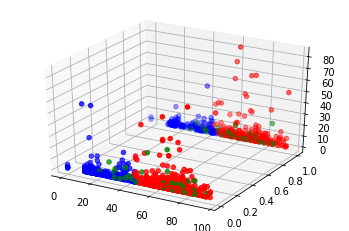

age_yrs vs disable vs hospdays


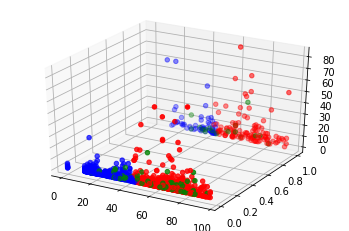

age_yrs vs died vs hospdays


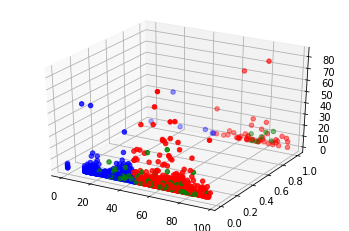

age_yrs vs hospdays vs hospdays


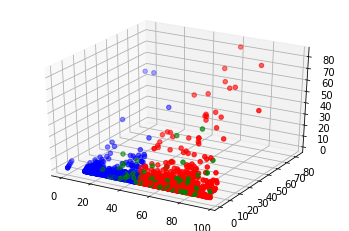

age_yrs vs recovd vs hospdays


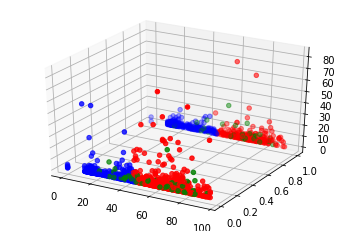

age_yrs vs infarct_myocardic vs hospdays


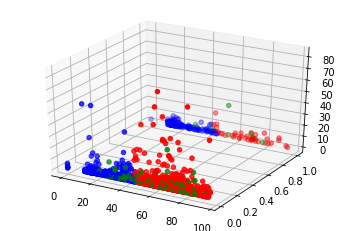

age_yrs vs coagulopathy vs hospdays


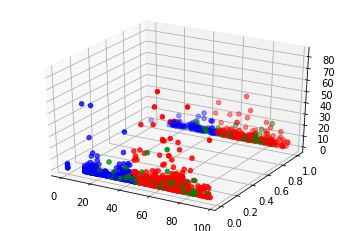

age_yrs vs anaphylactic vs hospdays


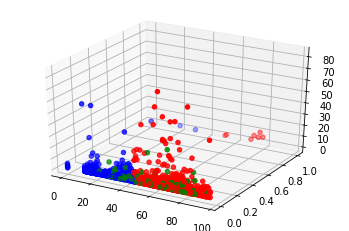

age_yrs vs myocarditis_pericarditis vs hospdays


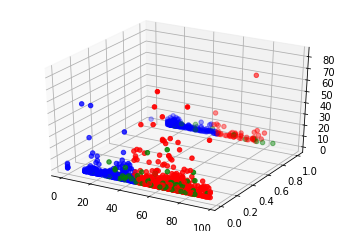

age_yrs vs epilepsy_convulsions vs hospdays


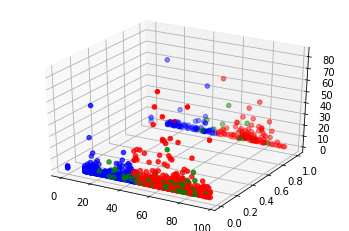

age_yrs vs covid19 vs hospdays


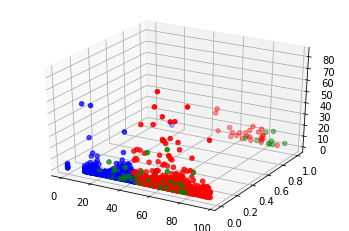

age_yrs vs guillain vs hospdays


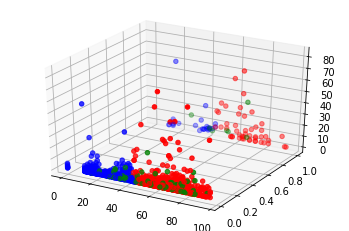

age_yrs vs polyneurapathy vs hospdays


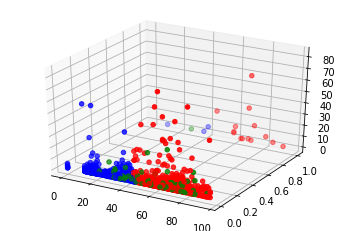

age_yrs vs multisystem vs hospdays


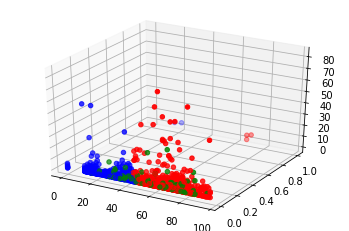

age_yrs vs narcolepsia vs hospdays


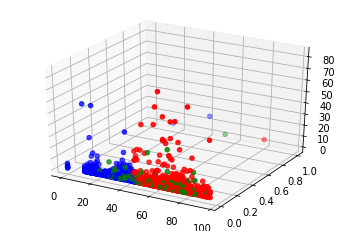

age_yrs vs pregnancy vs hospdays


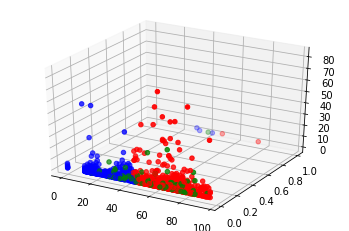

age_yrs vs stroke vs hospdays


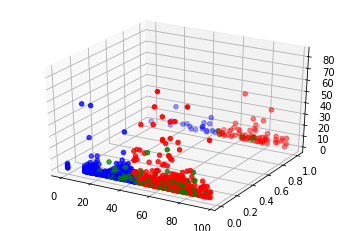

age_yrs vs transverse_myelitis vs hospdays


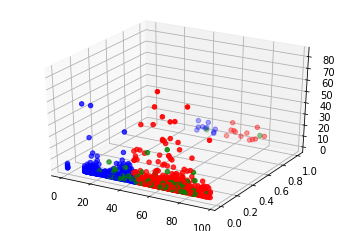

age_yrs vs autoimmuned vs hospdays


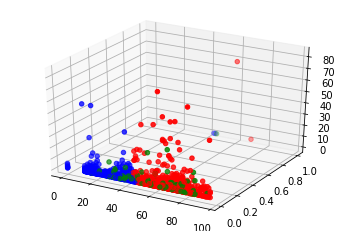

age_yrs vs adem vs hospdays


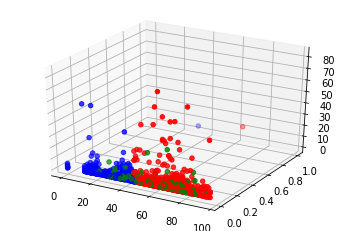

age_yrs vs multipleesclerosis vs hospdays


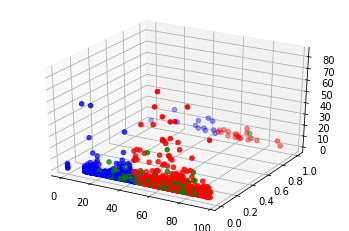

age_yrs vs opticneuritis vs hospdays


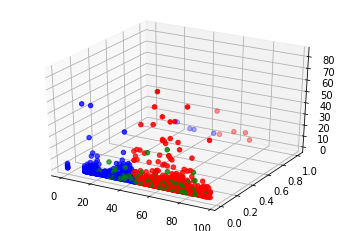

age_yrs vs cidp vs hospdays


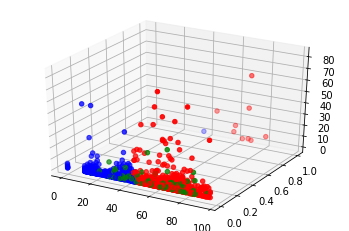

age_yrs vs encephalitis vs hospdays


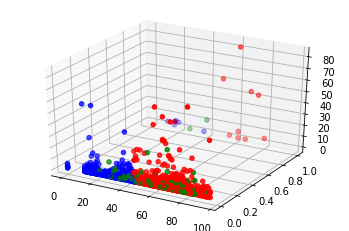

age_yrs vs myelitis vs hospdays


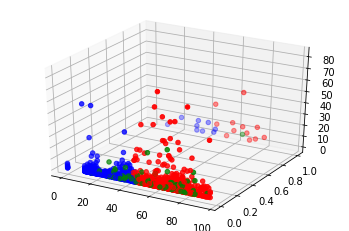

age_yrs vs encephalomyelitis vs hospdays


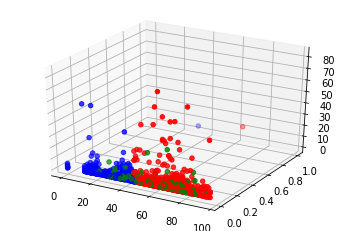

age_yrs vs meningitis vs hospdays


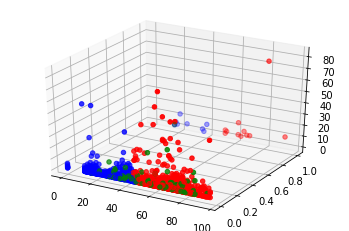

age_yrs vs encephalopathy vs hospdays


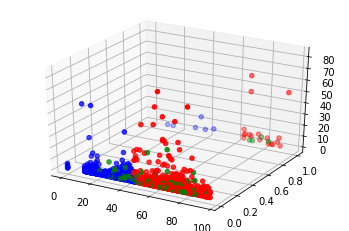

age_yrs vs ataxia vs hospdays


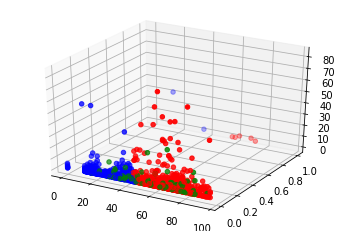

age_yrs vs noanaphylactic vs hospdays


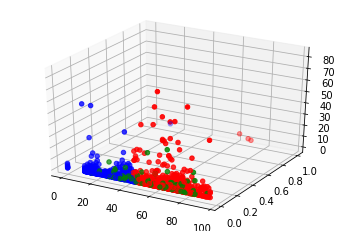

age_yrs vs days_to_onset_symptoms vs hospdays


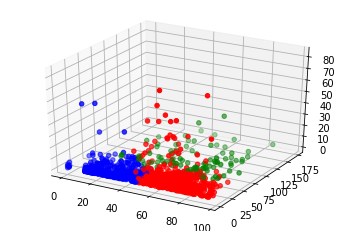

In [ ]:
### OBSERVAR QUE VARIABLES SON LAS QUE AUMENTAN LA CANTIDAD DE DÍAS DE HOSPITALIZACIÓN.
colormap = np.array(['Red', 'Blue', 'Green','Orange'])
variables=list(data_modelamiento.columns)
for element in variables :
  print('age_yrs'+" vs "+element+ " vs "+'hospdays')
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(data_modelamiento['age_yrs'], data_modelamiento[element],data_modelamiento['hospdays'], c=colormap[kmeans.labels_]);
  plt.show()

days_to_onset_symptoms vs vax_dose_series vs hospdays


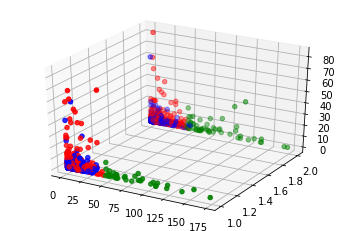

days_to_onset_symptoms vs age_yrs vs hospdays


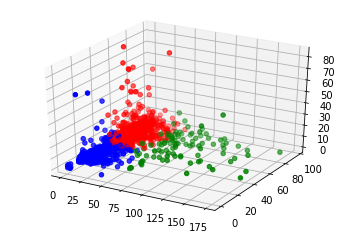

days_to_onset_symptoms vs sex vs hospdays


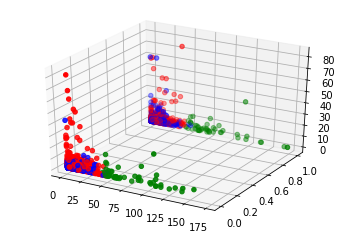

days_to_onset_symptoms vs er_ed_visit vs hospdays


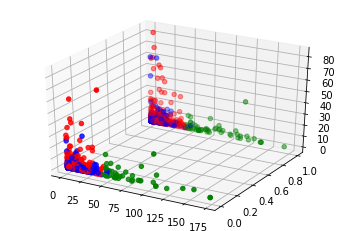

days_to_onset_symptoms vs l_threat vs hospdays


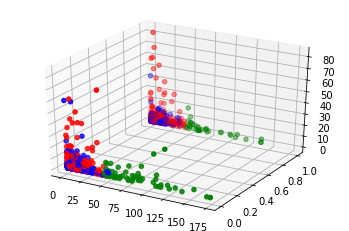

days_to_onset_symptoms vs disable vs hospdays


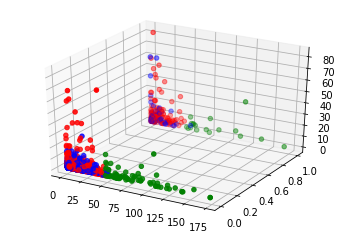

days_to_onset_symptoms vs died vs hospdays


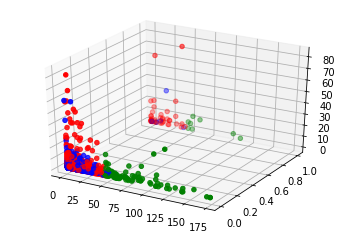

days_to_onset_symptoms vs hospdays vs hospdays


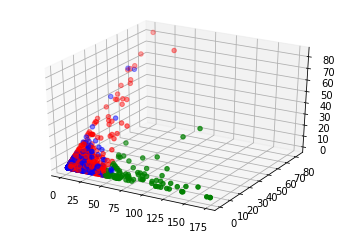

days_to_onset_symptoms vs recovd vs hospdays


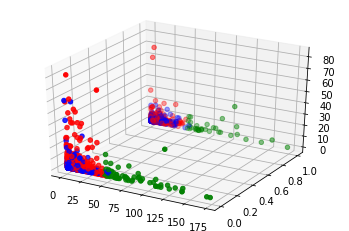

days_to_onset_symptoms vs infarct_myocardic vs hospdays


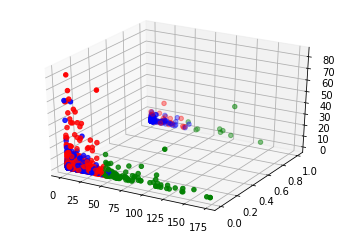

days_to_onset_symptoms vs coagulopathy vs hospdays


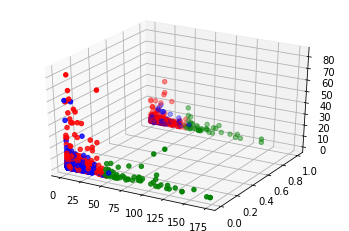

days_to_onset_symptoms vs anaphylactic vs hospdays


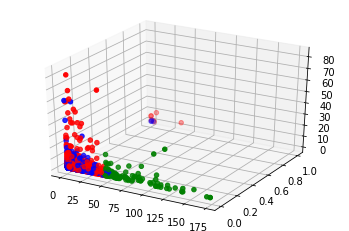

days_to_onset_symptoms vs myocarditis_pericarditis vs hospdays


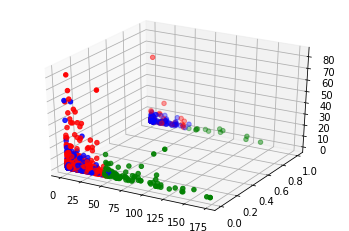

days_to_onset_symptoms vs epilepsy_convulsions vs hospdays


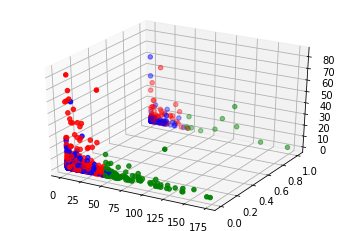

days_to_onset_symptoms vs covid19 vs hospdays


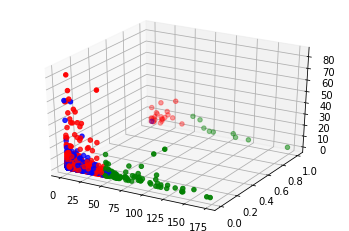

days_to_onset_symptoms vs guillain vs hospdays


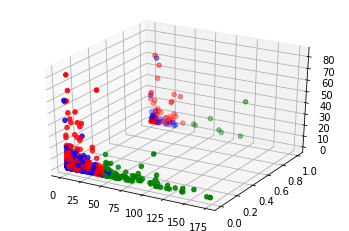

days_to_onset_symptoms vs polyneurapathy vs hospdays


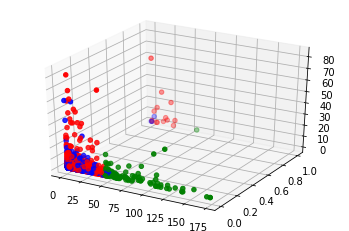

days_to_onset_symptoms vs multisystem vs hospdays


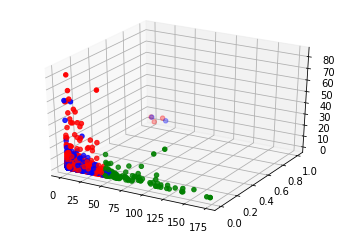

days_to_onset_symptoms vs narcolepsia vs hospdays


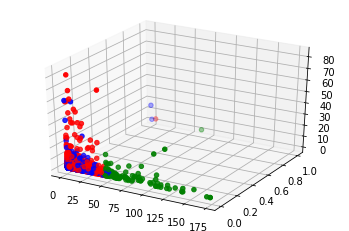

days_to_onset_symptoms vs pregnancy vs hospdays


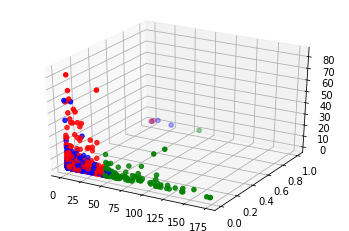

days_to_onset_symptoms vs stroke vs hospdays


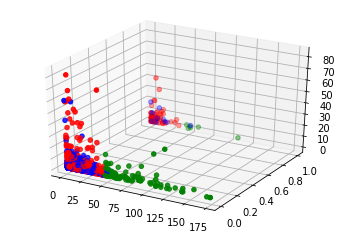

days_to_onset_symptoms vs transverse_myelitis vs hospdays


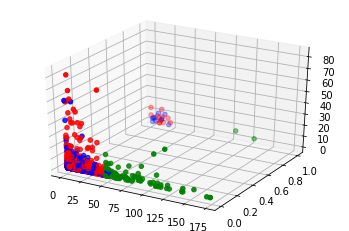

days_to_onset_symptoms vs autoimmuned vs hospdays


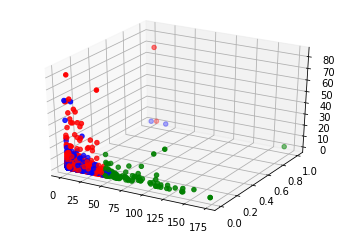

days_to_onset_symptoms vs adem vs hospdays


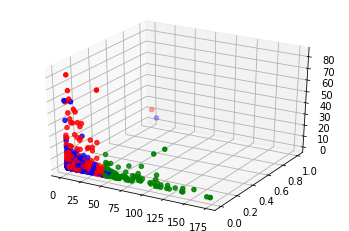

days_to_onset_symptoms vs multipleesclerosis vs hospdays


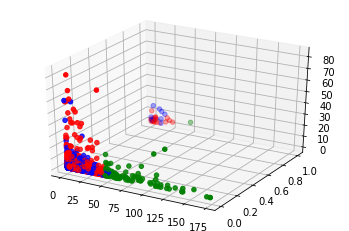

days_to_onset_symptoms vs opticneuritis vs hospdays


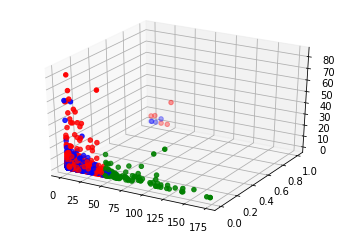

days_to_onset_symptoms vs cidp vs hospdays


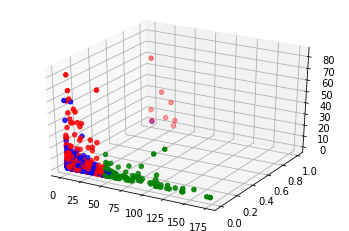

days_to_onset_symptoms vs encephalitis vs hospdays


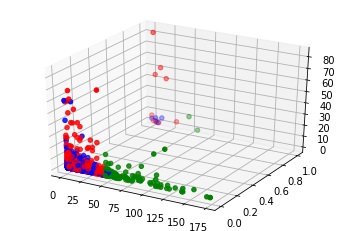

days_to_onset_symptoms vs myelitis vs hospdays


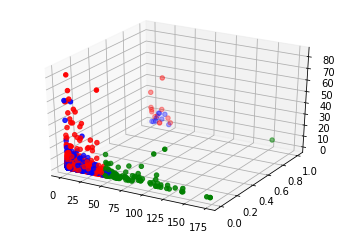

days_to_onset_symptoms vs encephalomyelitis vs hospdays


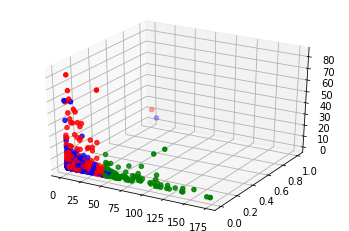

days_to_onset_symptoms vs meningitis vs hospdays


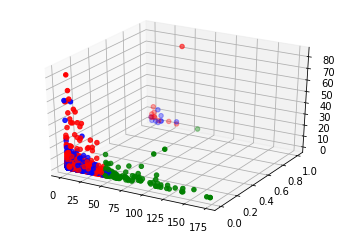

days_to_onset_symptoms vs encephalopathy vs hospdays


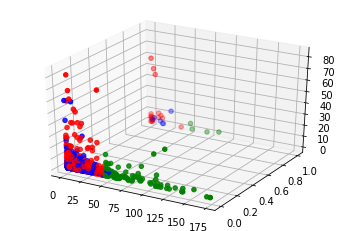

days_to_onset_symptoms vs ataxia vs hospdays


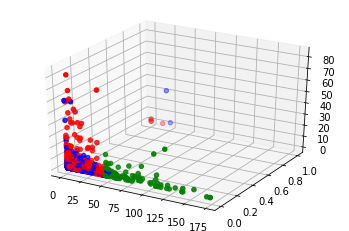

days_to_onset_symptoms vs noanaphylactic vs hospdays


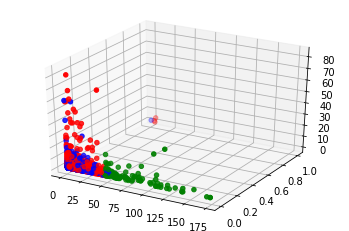

days_to_onset_symptoms vs days_to_onset_symptoms vs hospdays


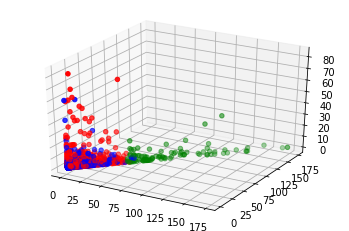

In [ ]:
### OBSERVAR QUE VARIABLES SON LAS QUE AUMENTAN LA CANTIDAD DE DÍAS DE HOSPITALIZACIÓN.
colormap = np.array(['Red', 'Blue', 'Green','Orange'])
variables=list(data_modelamiento.columns)
for element in variables :
  print('days_to_onset_symptoms'+" vs "+element+ " vs "+'hospdays')
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(data_modelamiento['days_to_onset_symptoms'], data_modelamiento[element],data_modelamiento['hospdays'], c=colormap[kmeans.labels_]);
  plt.show()

##5.3. DISTRIBUCIÓN DE VARIABLES Y CLUSTERS DE ACUERDO A LA EDAD E INCIO DE SÍTNOMAS.

days_to_onset_symptoms vs vax_dose_series vs age_yrs


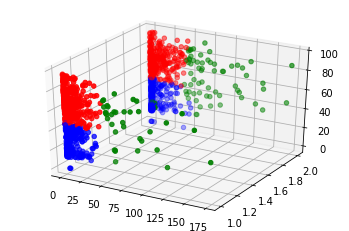

days_to_onset_symptoms vs age_yrs vs age_yrs


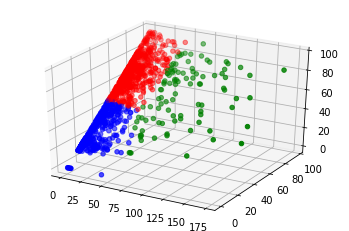

days_to_onset_symptoms vs sex vs age_yrs


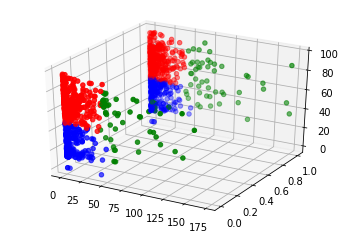

days_to_onset_symptoms vs er_ed_visit vs age_yrs


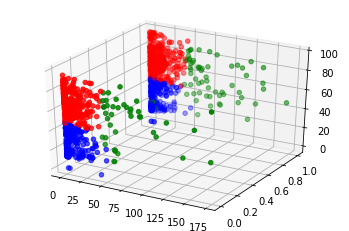

days_to_onset_symptoms vs l_threat vs age_yrs


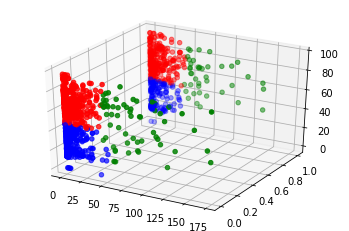

days_to_onset_symptoms vs disable vs age_yrs


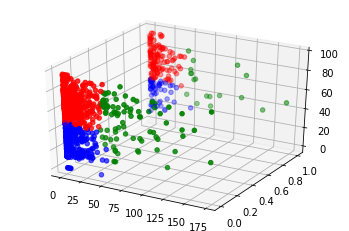

days_to_onset_symptoms vs died vs age_yrs


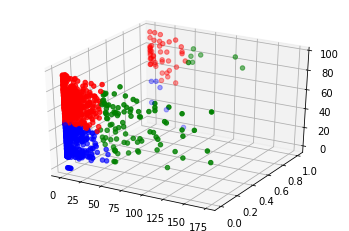

days_to_onset_symptoms vs hospdays vs age_yrs


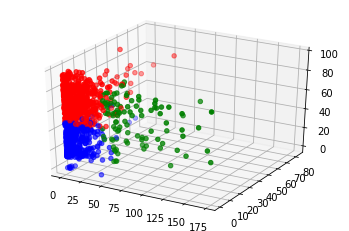

days_to_onset_symptoms vs recovd vs age_yrs


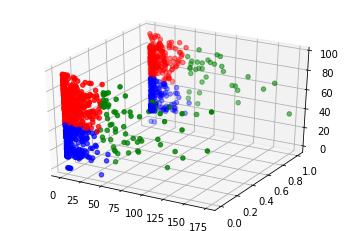

days_to_onset_symptoms vs infarct_myocardic vs age_yrs


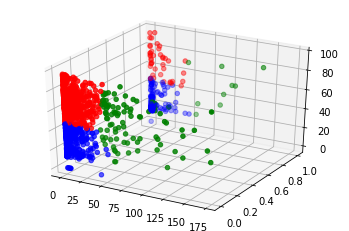

days_to_onset_symptoms vs coagulopathy vs age_yrs


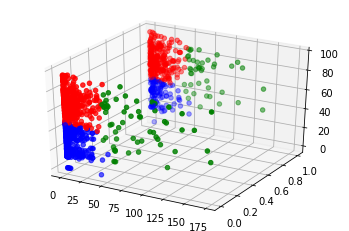

days_to_onset_symptoms vs anaphylactic vs age_yrs


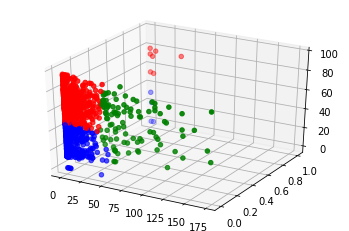

days_to_onset_symptoms vs myocarditis_pericarditis vs age_yrs


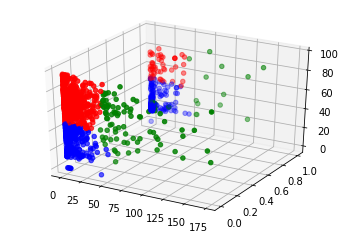

days_to_onset_symptoms vs epilepsy_convulsions vs age_yrs


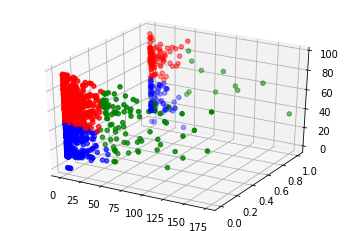

days_to_onset_symptoms vs covid19 vs age_yrs


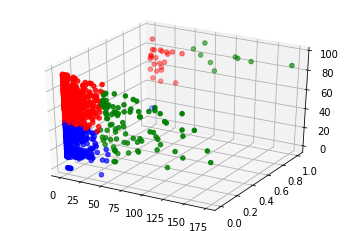

days_to_onset_symptoms vs guillain vs age_yrs


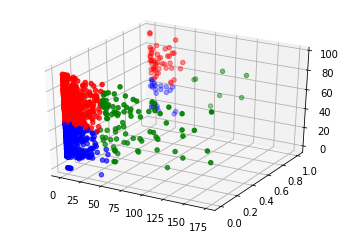

days_to_onset_symptoms vs polyneurapathy vs age_yrs


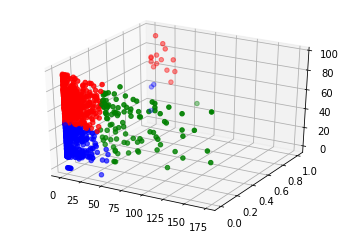

days_to_onset_symptoms vs multisystem vs age_yrs


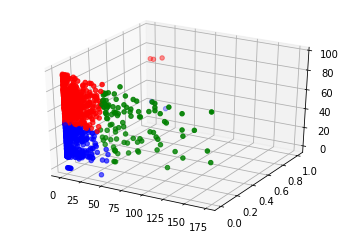

days_to_onset_symptoms vs narcolepsia vs age_yrs


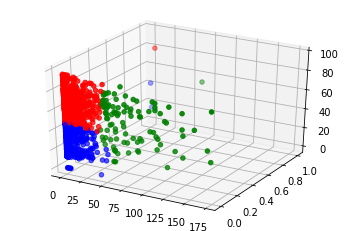

days_to_onset_symptoms vs pregnancy vs age_yrs


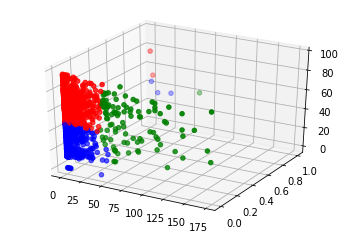

days_to_onset_symptoms vs stroke vs age_yrs


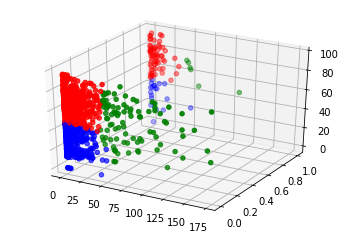

days_to_onset_symptoms vs transverse_myelitis vs age_yrs


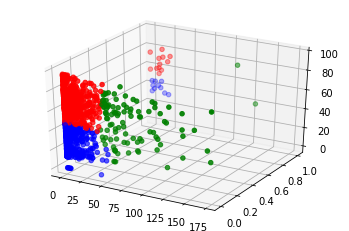

days_to_onset_symptoms vs autoimmuned vs age_yrs


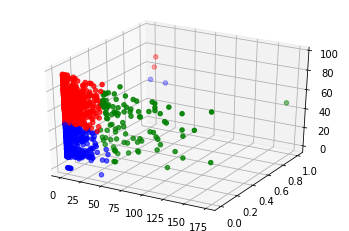

days_to_onset_symptoms vs adem vs age_yrs


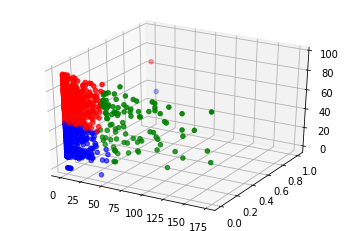

days_to_onset_symptoms vs multipleesclerosis vs age_yrs


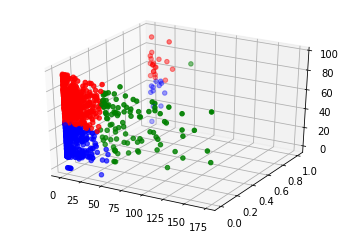

days_to_onset_symptoms vs opticneuritis vs age_yrs


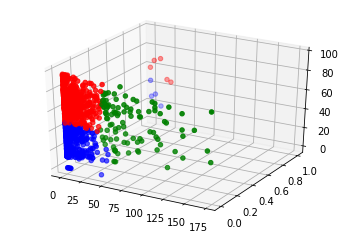

days_to_onset_symptoms vs cidp vs age_yrs


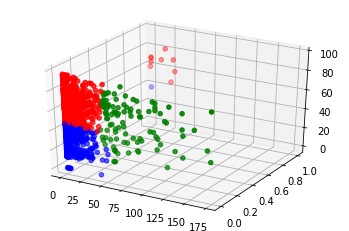

days_to_onset_symptoms vs encephalitis vs age_yrs


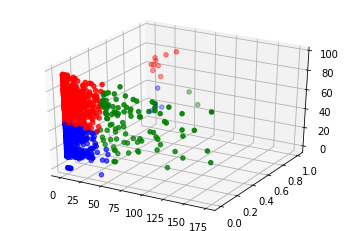

days_to_onset_symptoms vs myelitis vs age_yrs


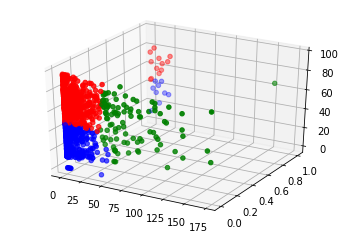

days_to_onset_symptoms vs encephalomyelitis vs age_yrs


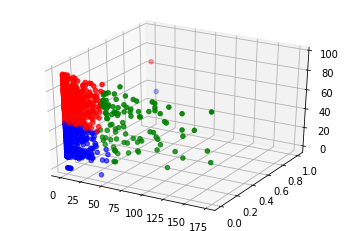

days_to_onset_symptoms vs meningitis vs age_yrs


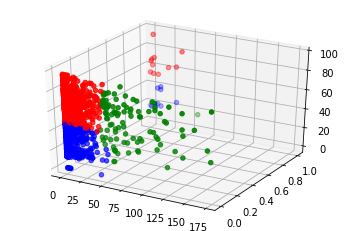

days_to_onset_symptoms vs encephalopathy vs age_yrs


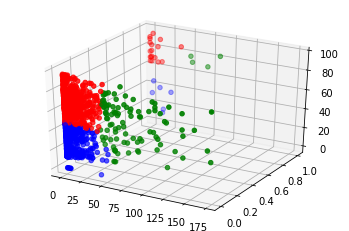

days_to_onset_symptoms vs ataxia vs age_yrs


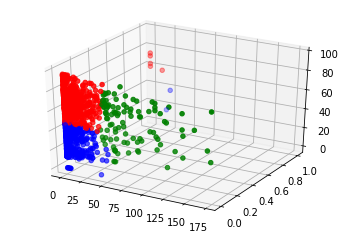

days_to_onset_symptoms vs noanaphylactic vs age_yrs


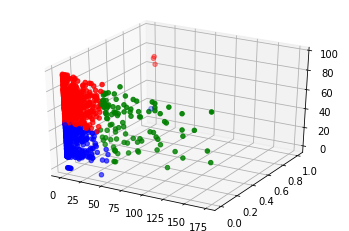

days_to_onset_symptoms vs days_to_onset_symptoms vs age_yrs


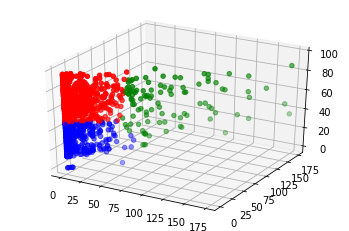

In [ ]:
### OBSERVAR QUE VARIABLES SON LAS QUE AUMENTAN LA CANTIDAD DE DÍAS DE HOSPITALIZACIÓN.
colormap = np.array(['Red', 'Blue', 'Green','Orange'])
variables=list(data_modelamiento.columns)
for element in variables :
  print('days_to_onset_symptoms'+" vs "+element+ " vs "+'age_yrs')
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(data_modelamiento['days_to_onset_symptoms'], data_modelamiento[element],data_modelamiento['age_yrs'], c=colormap[kmeans.labels_]);
  plt.show()

##5.3. DENDOGRAMA AL EMPLEAR TODA LA DATA MODELADA EN CLUSTERS

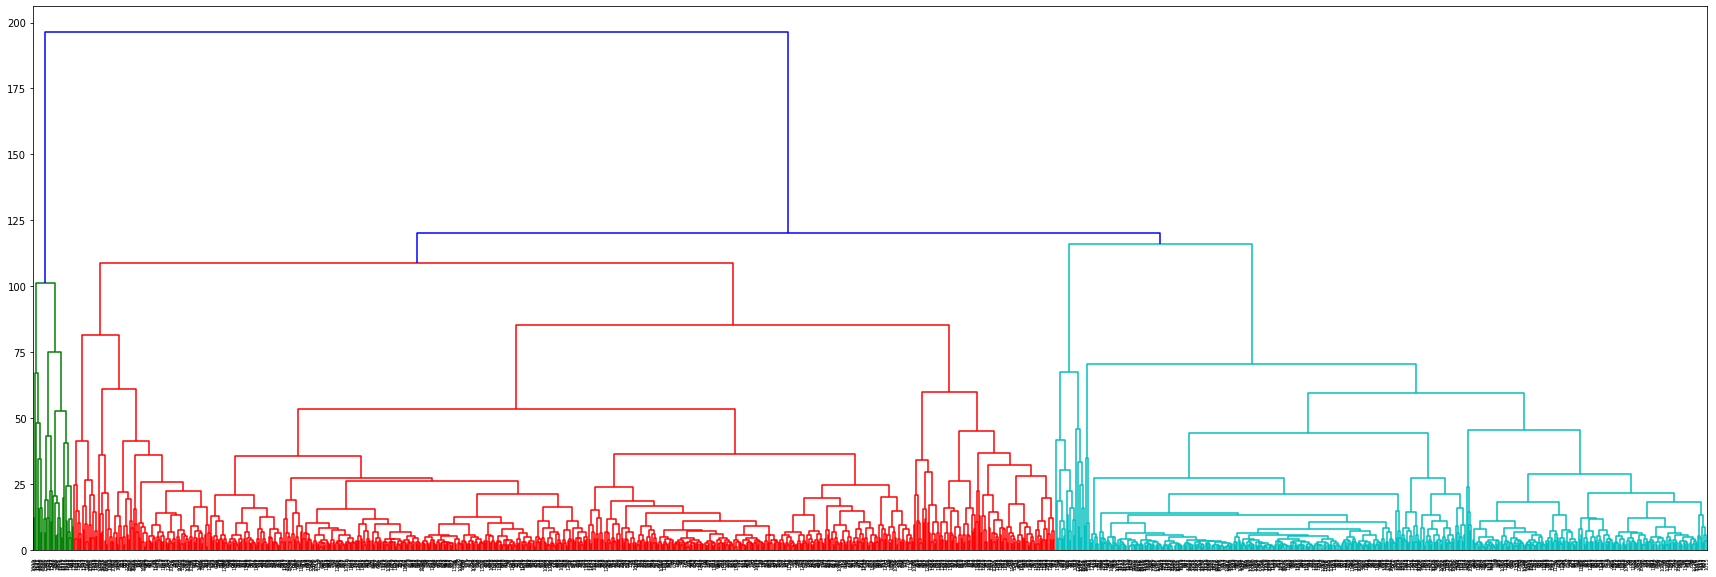

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linked = linkage(data_modelamiento, method='complete', metric='euclidean')

thres = 120
plt.figure(figsize=(30, 10))
dendrogram(linked,
            orientation='top',
            color_threshold=thres,
            distance_sort='descending')
plt.show()

##5.4. PCA AL USAR variables DÍAS DE HOSPITALIZACIÓN, EDAD, Y DÍAS DESDE LA VACUNACIÓN HASTA EL INICIO DE SÍNTOMAS


In [ ]:
### determinar cual es la data PCA
data_pca=data_modelamiento[['age_yrs','days_to_onset_symptoms','hospdays']]

#Data scaler
from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA

(1373, 2)
(1373, 3)


Text(0, 0.5, 'Second Principal Component')

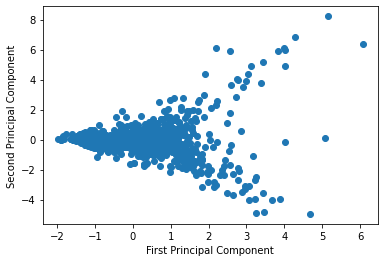

In [ ]:
data_scaler = StandardScaler()
data_scaler.fit(data_pca)
scaled_data_frame = data_scaler.transform(data_pca)

pca = PCA(n_components = 2)
pca.fit(scaled_data_frame)

x_pca = pca.transform(scaled_data_frame)
print(x_pca.shape)
print(scaled_data_frame.shape)

plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=data_pca.columns.values)
loadings

PC1       PC2
age_yrs                 0.684178 -0.021475
days_to_onset_symptoms  0.547423 -0.645350
hospdays                0.481901  0.763585

Text(0, 0.5, 'Second Principal Component')

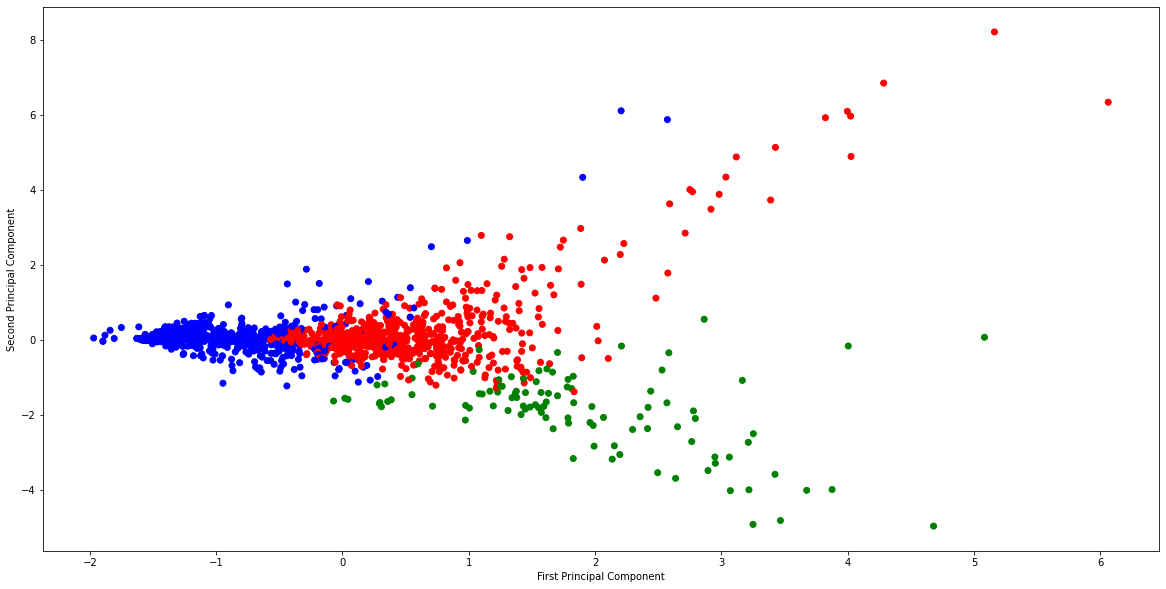

In [ ]:

colormap = np.array(['Red', 'Blue',  'Green'])
plt.figure(figsize=(20,10))
plt.scatter(x_pca[:,0],x_pca[:,1], c=colormap[kmeans.labels_])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

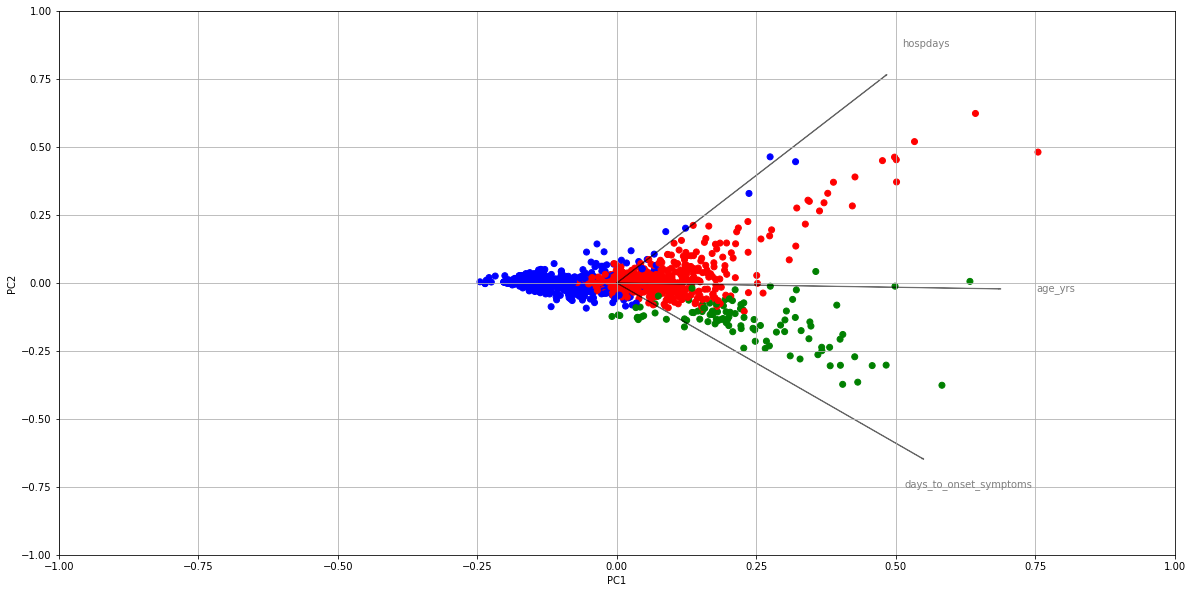

In [ ]:
def myplot(score,coeff,labels=None, colors=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c = colors)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'black',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'gray', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'gray', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

    #Call the function. Use only the 2 PCs.
plt.figure(figsize=(20,10))
myplot(x_pca[:,0:2],np.transpose(pca.components_[0:2, :]), 
       labels=data_pca.columns,
       colors=colormap[kmeans.labels_])
plt.show()

Text(0, 0.5, 'Medida de la varianza explicada')

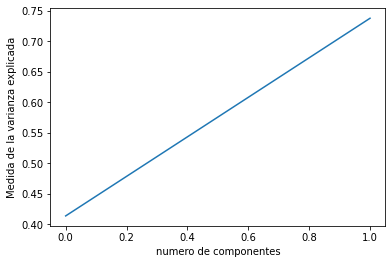

In [ ]:
pca_ = PCA().fit(data_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('Medida de la varianza explicada')